# Importing Libraries

In [140]:
import psycopg
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm

# Data Gathering

In [ ]:
dbname = 'everything2024'
user = 'username'
password = 'password'
host = 'pg.mlds.northwestern.edu'
port = '5432' 

In [13]:
# create a connection
connection = psycopg.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host,
    port=port
)

In [14]:
# create a cursor
cursor = connection.cursor()

In [15]:
# execute a query
cursor.execute("SELECT * FROM mlds422.movies;")
result = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
df = pd.DataFrame(result, columns=column_names)

In [16]:
df.head()

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count
0,1,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,2010-02-12,2010-06-29,83.0,49,144,53.0,254287.0
1,2,Please Give,Kate has a lot on her mind. There's the ethics...,R,Comedy,Nicole Holofcener,2010-04-30,2010-10-19,90.0,86,140,64.0,11567.0
2,3,10,Blake Edwards' 10 stars Dudley Moore as George...,R,"Comedy, Romance",Blake Edwards,1979-10-05,1997-08-27,118.0,68,22,53.0,14670.0
3,4,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",None,"Classics, Drama",Sidney Lumet,2057-04-13,2001-03-06,95.0,100,51,97.0,105000.0
4,5,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,2054-01-01,2003-05-20,127.0,89,27,74.0,68860.0


# Data Cleaning & Exploratory Data Analysis

### 1. Find the number of movies that were released in theatres each year.


In [59]:
# check the basic information of the dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16455 entries, 0 to 16637
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_id            16455 non-null  int64         
 1   movie_title         16455 non-null  object        
 2   movie_info          16435 non-null  object        
 3   rating              11674 non-null  object        
 4   genre               16438 non-null  object        
 5   directors           16345 non-null  object        
 6   in_theaters_date    15671 non-null  datetime64[ns]
 7   on_streaming_date   16453 non-null  datetime64[ns]
 8   runtime_in_minutes  16455 non-null  float64       
 9   critic_rating       16455 non-null  int64         
 10  critic_count        16455 non-null  int64         
 11  audience_rating     16207 non-null  float64       
 12  audience_count      16212 non-null  float64       
 13  in_theaters_year    15671 non-null  float64       


From here, we can see that there are some null-values on the in_theaters_date and the date type format is object. So, we need to replace the format of the date.

Check whether there is duplicated data or not

In [60]:
# check if there is a duplicated data
df.duplicated().sum()

np.int64(0)

In [61]:
# change the format for the date into the correct date format
df['in_theaters_date'] = pd.to_datetime(df['in_theaters_date'], format = '%m/%d/%y')
df['on_streaming_date'] = pd.to_datetime(df['on_streaming_date'], format = '%m/%d/%y')

In [62]:
# create another variable to store the year and find the number of movies released each year
df['in_theaters_year'] = df['in_theaters_date'].dt.year

In [63]:
# group by the released year and count the movie id to calculate the total movies in each released year
count_movie_by_year = df.groupby('in_theaters_year')['movie_id'].count().reset_index()
count_movie_by_year

,in_theaters_year,movie_id
0,1920.0,4
1,1921.0,2
2,1922.0,5
3,1923.0,5
4,1924.0,6
...,...,...
95,2015.0,643
96,2016.0,613
97,2017.0,538
98,2018.0,587


From the table above, we can see that having a release year in theaters beyond 2024 does not make sense, as the code is created in 2024.

**What to do?**

For the release year greater than 2024, we will deduct it by 100 to address input errors. For example, we assume the user mistakenly input 2065, but it should be 1965.

We will assume we do this code on 2025-01-01. So, we will change the value of the year > 2024

In [64]:
# when the year > 2024, deduct 100 years, or else, remain the same
df['in_theaters_date'] = np.where(df['in_theaters_date'].dt.year > 2024, 
                        df['in_theaters_date'] - pd.DateOffset(years = 100), 
                        df['in_theaters_date'])

In [65]:
# use dt.year to take the year of a date format
df['in_theaters_year'] = df['in_theaters_date'].dt.year

In [66]:
# group by the released year and count the movie id to calculate the total movies in each released year and use .columns to change the columns name
count_movie_by_year = df.groupby('in_theaters_year')['movie_id'].count().reset_index()
count_movie_by_year.columns = ['in_theaters_year', 'n_movies']
count_movie_by_year

,in_theaters_year,n_movies
0,1920.0,4
1,1921.0,2
2,1922.0,5
3,1923.0,5
4,1924.0,6
...,...,...
95,2015.0,643
96,2016.0,613
97,2017.0,538
98,2018.0,587


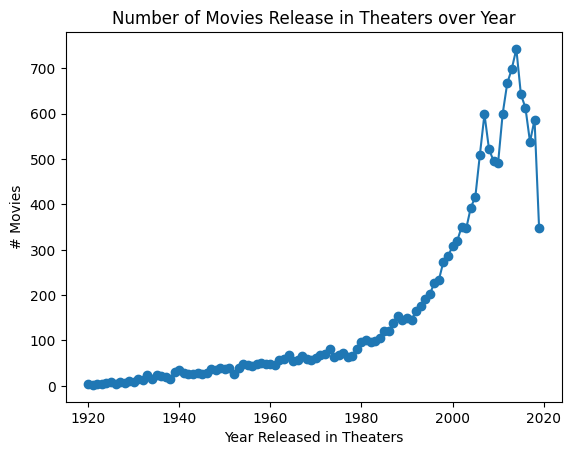

In [67]:
# plot the scatterplot using .plot(x axis variable, y axis variable), change the title and xlabel, ylabel
plt.plot(count_movie_by_year['in_theaters_year'], count_movie_by_year['n_movies'], marker = 'o')
plt.title("Number of Movies Release in Theaters over Year")
plt.xlabel("Year Released in Theaters")
plt.ylabel("# Movies")
plt.show()

By observing the graph, there is a sudden drop in movies releases in 2020 and above. This anomaly might be happened because of the input errors, similar to the assumptions I made earlier. I noticed that the data might by accurate until 2019, and the years after might have been incorrectly entered.

To address this problem, I will deduct 100 years from 2020 and beyond to clean the data. This adjustment makes sense, as it will have an increasing trend.

In [68]:
# from the graph, we can see that we have a problem on our data, so for every theather release date > 2019, we will deduct 100, or else, just take the date.
df['in_theaters_date'] = np.where(df['in_theaters_date'].dt.year > 2019, 
                        df['in_theaters_date'] - pd.DateOffset(years = 100), 
                        df['in_theaters_date'])

In [69]:
# dt.year is used to take the year of a date data
df['in_theaters_year'] = df['in_theaters_date'].dt.year

In [70]:
# group by the released year and count the movie id, then change the columns name by .columns
count_movie_by_year = df.groupby('in_theaters_year')['movie_id'].count().reset_index()
count_movie_by_year.columns = ['in_theaters_year', 'n_movies']
count_movie_by_year

,in_theaters_year,n_movies
0,1920.0,4
1,1921.0,2
2,1922.0,5
3,1923.0,5
4,1924.0,6
...,...,...
95,2015.0,643
96,2016.0,613
97,2017.0,538
98,2018.0,587


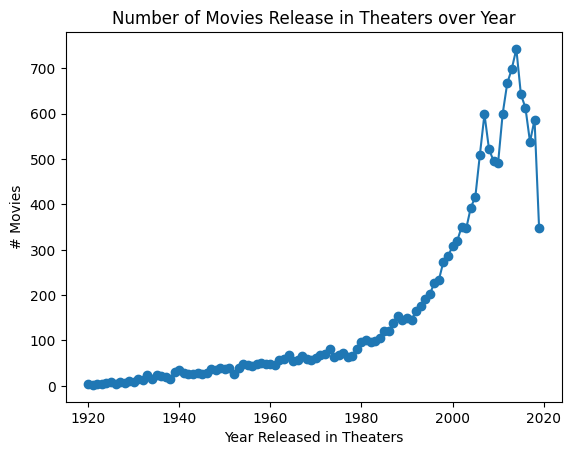

In [71]:
plt.plot(count_movie_by_year['in_theaters_year'], count_movie_by_year['n_movies'], marker = 'o')
plt.title("Number of Movies Release in Theaters over Year")
plt.xlabel("Year Released in Theaters")
plt.ylabel("# Movies")
plt.show()

### Assumptions that I made:
The data includes movie release years in theaters up to 2069. Here, I assume there was an error in the data entry. After analyzing the line chart, I noticed that the data only makes sense up to 2019. Therefore, I adjusted the release years greater than 2019 by deducting 100 years. This correction makes the data more accurate.

### Insights from the graph:
The graph shows a steady increase in the total number of movies released from 1920 to 2000. After 2000, there is a fluctuation, with some years showing an increase in releases and others showing a decline.

### Next plan for the data cleaning:
I also assume there are errors in the on_streaming_date. My next step is to clean this data by deducting 100 years for streaming release dates after 2019.

In [72]:
# check for the on streaming date as well
df['on_streaming_date'] = np.where(df['on_streaming_date'].dt.year > 2019, 
                        df['on_streaming_date'] - pd.DateOffset(years = 100), 
                        df['on_streaming_date'])
df['on_streaming_year'] = df['on_streaming_date'].dt.year

In [73]:
# grouped by on_streaming_year and count the movie_id, then change the column name by .columns
count_movie_streaming_by_year = df.groupby('on_streaming_year')['movie_id'].count().reset_index()
count_movie_streaming_by_year.columns = ['on_streaming_year', 'n_movies']
count_movie_streaming_by_year.head()

,on_streaming_year,n_movies
0,1986.0,1
1,1987.0,1
2,1988.0,3
3,1989.0,1
4,1990.0,11


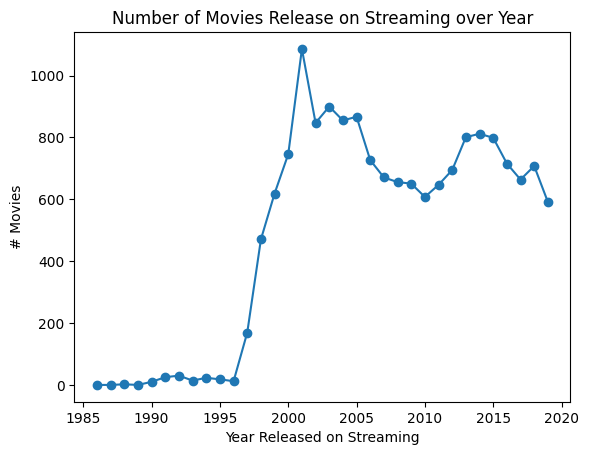

In [74]:
plt.plot(count_movie_streaming_by_year['on_streaming_year'], count_movie_streaming_by_year['n_movies'], marker = 'o')
plt.title("Number of Movies Release on Streaming over Year")
plt.xlabel("Year Released on Streaming")
plt.ylabel("# Movies")
plt.show()

Seeing the grouped count and line plot, it shows that there is only one movie with an adjusted on_streaming_year of 1935. After that, the data jumps to 1986. Since this is just a single data point and does not align with the trend, I will remove thie entry.

In [75]:
# remove the datapoint for 1935 on streaming release, because it is definitly an outlier
df = df[df['on_streaming_year'] != 1935]

In [76]:
# grouped by on_streaming_year and count the movie_id to get the total movies on each year
count_movie_streaming_by_year = df.groupby('on_streaming_year')['movie_id'].count().reset_index()
count_movie_streaming_by_year.columns = ['on_streaming_year', 'n_movies']
count_movie_streaming_by_year.head()

,on_streaming_year,n_movies
0,1986.0,1
1,1987.0,1
2,1988.0,3
3,1989.0,1
4,1990.0,11


### 2. Looking only at movies that were released in theatres before 2010

In [77]:
# movies that were released in theaters before 2010
df_filtered = df[df['in_theaters_date'] < '2010-01-01']

In [78]:
# Find the 5 highest rated movies by critics (critic_rating)
df_filtered.sort_values(by = 'critic_rating', ascending = False).head(5)

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,in_theaters_year,on_streaming_year
591,576,The Maltese Falcon,After two previous film versions of Dashiell H...,PG,"Drama, Mystery & Suspense",John Huston,1941-10-18,2000-02-15,101.0,100,55,91.0,57767.0,1941.0,2000.0
11976,11943,Roger & Me,Michael Moore's wickedly iconoclastic document...,R,"Documentary, Special Interest",Michael Moore,1989-06-01,2003-07-05,91.0,100,30,79.0,19978.0,1989.0,2003.0
15656,15639,Ugetsu (Ugetsu monogatari),Presented in a manner as eerie as it is heartb...,None,"Art House & International, Drama, Mystery & Su...",Kenji Mizoguchi,1954-09-07,2005-11-08,96.0,100,27,94.0,6858.0,1954.0,2005.0
693,694,Sahara,Sahara is a World War II film about a British-...,None,"Action & Adventure, Classics, Drama",Zoltan Korda,1943-11-11,2001-12-11,97.0,100,10,86.0,4874.0,1943.0,2001.0
2763,2722,Antonio Gaud√≠,"Antonio Gaudi's startling, unique architectura...",None,"Art House & International, Documentary, Drama,...",Hiroshi Teshigahara,1986-03-05,1999-12-28,97.0,100,11,74.0,425.0,1986.0,1999.0


In [79]:
# Find the 5 highest rated movies by the general audience (audience_rating)
df_filtered.sort_values('audience_rating', ascending = False).head(5)

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,in_theaters_year,on_streaming_year
3229,3197,Been Rich All My Life,This documentary follows the most unlikely tro...,None,"Documentary, Musical & Performing Arts, Specia...",Heather MacDonald,2006-07-21,2006-11-21,81.0,80,30,100.0,961.0,2006.0,2006.0
1283,1289,La Ciudad (The City),This American film (in Spanish) focuses on Lat...,None,"Art House & International, Drama",David Riker,1998-09-13,2005-06-14,88.0,83,12,100.0,313.0,1998.0,2005.0
1846,1801,Ice People,While the mainstream world rolls on indefinite...,None,"Documentary, Special Interest",Anne Aghion,2008-04-26,2009-11-10,77.0,89,9,100.0,37.0,2008.0,2009.0
14059,14038,The English Surgeon,The English Surgeon' is the true-life tale of ...,PG,"Art House & International, Documentary, Specia...",Geoffrey Smith,2009-07-31,2009-11-03,93.0,89,19,98.0,3602.0,2009.0,2009.0
6747,6704,The Godfather,Popularly viewed as one of the best American f...,R,Drama,Francis Ford Coppola,1972-03-24,2001-10-09,175.0,98,91,98.0,732931.0,1972.0,2001.0


All of the movies above doesn't seems popular. So, we need to find a way to find the popular movies.

### 3. Create a new DataFrame containing only “popular” movies that were released in theatres before 2010.
• Assume popular movies are those with more audience reviews than the average number of audience reviews of all movies before 2010\
• Find the 5 highest rated movies by critics (critic_rating)\
• Find the 5 highest rated movies by the general audience (audience_rating)\
• Take a look at the movie titles – these top movies should make more sense

In [80]:
# movies that were released in theaters before 2010
df_filtered = df[df['in_theaters_date'] < '2010-01-01']

# take the mean of the audience count
mean_audience_review = df_filtered['audience_count'].mean()

# create a new df and take the audience count which is greater than the average audience review count
df_popular = df_filtered[df_filtered['audience_count'] > mean_audience_review]

In [81]:
# Find the 5 highest rated movies by critics (critic_rating)
# sort values by critic rating and top 5, means descending, so ascending = False
df_popular.sort_values('critic_rating', ascending = False).head(5)

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,in_theaters_year,on_streaming_year
9636,9588,Mary Poppins,Practically Perfect In Every Way' Mary Poppins...,G,"Classics, Comedy, Kids & Family, Musical & Per...",Robert Stevenson,1964-08-26,1998-03-24,139.0,100,50,86.0,682310.0,1964.0,1998.0
15439,15415,Toy Story,"Woody, a traditional pull-string talking cowbo...",G,"Animation, Comedy, Kids & Family",John Lasseter,1995-11-22,2001-03-20,80.0,100,88,92.0,1109209.0,1995.0,2001.0
15440,15416,Toy Story 2,"Toy Story 2' is the exciting, all-new sequel t...",G,"Animation, Comedy, Kids & Family",John Lasseter,1999-11-24,2000-10-17,92.0,100,169,86.0,999952.0,1999.0,2000.0
11227,11194,Pinocchio,When the gentle woodcarver Geppetto (Christian...,G,"Animation, Kids & Family, Musical & Performing...","Hamilton Luske, Ben Sharpsteen, Walt Disney, W...",1940-02-07,2009-03-10,88.0,100,51,73.0,279248.0,1940.0,2009.0
13557,13528,The Terminator,A Cyborg has been sent from the future on a de...,R,"Action & Adventure, Science Fiction & Fantasy",James Cameron,1984-10-26,1997-09-03,108.0,100,61,89.0,775856.0,1984.0,1997.0


In [82]:
# Find the 5 highest rated movies by the general audience (audience_rating)
df_popular.sort_values('audience_rating', ascending = False).head(5)

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,in_theaters_year,on_streaming_year
12463,12436,The Shawshank Redemption,"In 1946, a banker named Andy Dufresne (Tim Rob...",R,Drama,Frank Darabont,1994-09-10,1998-01-27,142.0,90,71,98.0,885508.0,1994.0,1998.0
6747,6704,The Godfather,Popularly viewed as one of the best American f...,R,Drama,Francis Ford Coppola,1972-03-24,2001-10-09,175.0,98,91,98.0,732931.0,1972.0,2001.0
851,835,GoodFellas,Martin Scorsese explores the life of organized...,R,Drama,Martin Scorsese,1990-09-19,1997-03-26,146.0,96,95,97.0,428871.0,1990.0,1997.0
4435,4407,Cidade de Deus (City of God),Fernando Meirelles' City of God is a sweeping ...,R,"Action & Adventure, Art House & International,...","Fernando Meirelles, K√°tia Lund",2003-01-17,2004-06-08,130.0,91,159,97.0,251959.0,2003.0,2004.0
5706,5676,Star Wars: Episode V - The Empire Strikes Back,The second entry in George Lucas' Star Wars tr...,PG,"Action & Adventure, Drama, Science Fiction & F...",Irvin Kershner,1980-06-20,2004-09-21,124.0,95,98,97.0,1055106.0,1980.0,2004.0


The popular movie titles here are more reasonable, as they should be widely recognized by many people.

### 4. Using your new DataFrame (popular movies released in theatres before 2010), answer the following questions about the rating column:
• What percent of movies fall under each type of rating (R, PG-13, etc.)? What are your takeaways from the summary table?\
• Create a visualization that shows for each rating (R, PG-13, etc.), the average critic rating and the average audience rating. What are your takeaways from the visualization?

In [83]:
# What percent of movies fall under each type of rating (R, PG-13, etc.)? What are your takeaways from the summary table?

# group by rating and calculate the number of movies
rating_count = df_popular.groupby('rating')['movie_id'].count().reset_index()
# change the column name
rating_count.columns = ['rating', 'n_movies']

# count the total movies to calculate the percentage rating
total_movie = rating_count['n_movies'].sum()
rating_count['percent_rating'] = rating_count['n_movies'] / total_movie * 100
rating_count

,rating,n_movies,percent_rating
0,G,64,6.432161
1,PG,195,19.597990
2,PG-13,413,41.507538
3,R,323,32.462312


From the data, we can see that most movies fall under the PG-13 and R ratings, which is targeted for adult audience. On the contrary, PG and G ratings, which are the family-friendly movies, contribute much less. This means that the majority of the movies listed are towards more mature audience.

In [84]:
# want to calculate the critic and audience average rating
# grouped by rating and find the mean of the critic and audience rating by itself, then merged it together

avg_critic_rating = df_popular.groupby('rating')['critic_rating'].mean().reset_index()
avg_audience_rating = df_popular.groupby('rating')['audience_rating'].mean().reset_index()
merged_avg_rating = pd.merge(avg_critic_rating, avg_audience_rating, on = "rating")
merged_avg_rating

,rating,critic_rating,audience_rating
0,G,77.765625,74.781250
1,PG,59.266667,65.266667
2,PG-13,49.268765,62.523002
3,R,61.811146,71.182663


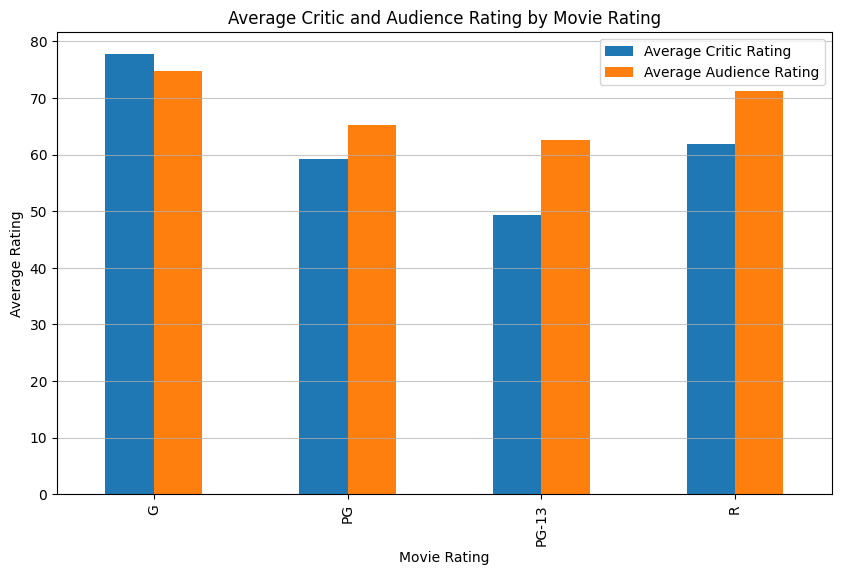

In [85]:
# plot the bargraph defining the kind = "bar", the x and y axis and also modify the title, label, and legend
merged_avg_rating.plot(
    x = "rating",
    y = ["critic_rating", "audience_rating"],
    kind = "bar",
    figsize = (10, 6)
)

plt.title("Average Critic and Audience Rating by Movie Rating")
plt.xlabel("Movie Rating")
plt.ylabel("Average Rating")
plt.legend(["Average Critic Rating", "Average Audience Rating"])
plt.grid(axis="y",  alpha=0.7)

plt.show()

**Insights:**
- Audience rating are generally higher than critic ratings, except for G-rated movies.
- G-rated movies have the highest average rating for both critic and audiences, which means that the film are the most universally appreciated.
- R-rated movies show that the average rating is higher for the audience than critics. This may be beacause the film is prefered for a matrue audience preference, which is not align with the critics expectations.
- PG-13 movies has the lowest average for both critics and audience ratings, which means there is a potential that it doesn't meet the standard, but for the audience rating, the average rating is slighly lower than PG, which means it is still appealing for general audience, but not for critics.
- PG-related movies have moderate ratings, this may be because of the light themes, which make them appealing to families and casual viewers.



### 5. Create a pair plot of the new DataFrame. What are 3 insights you can take away from looking at the pair plot?

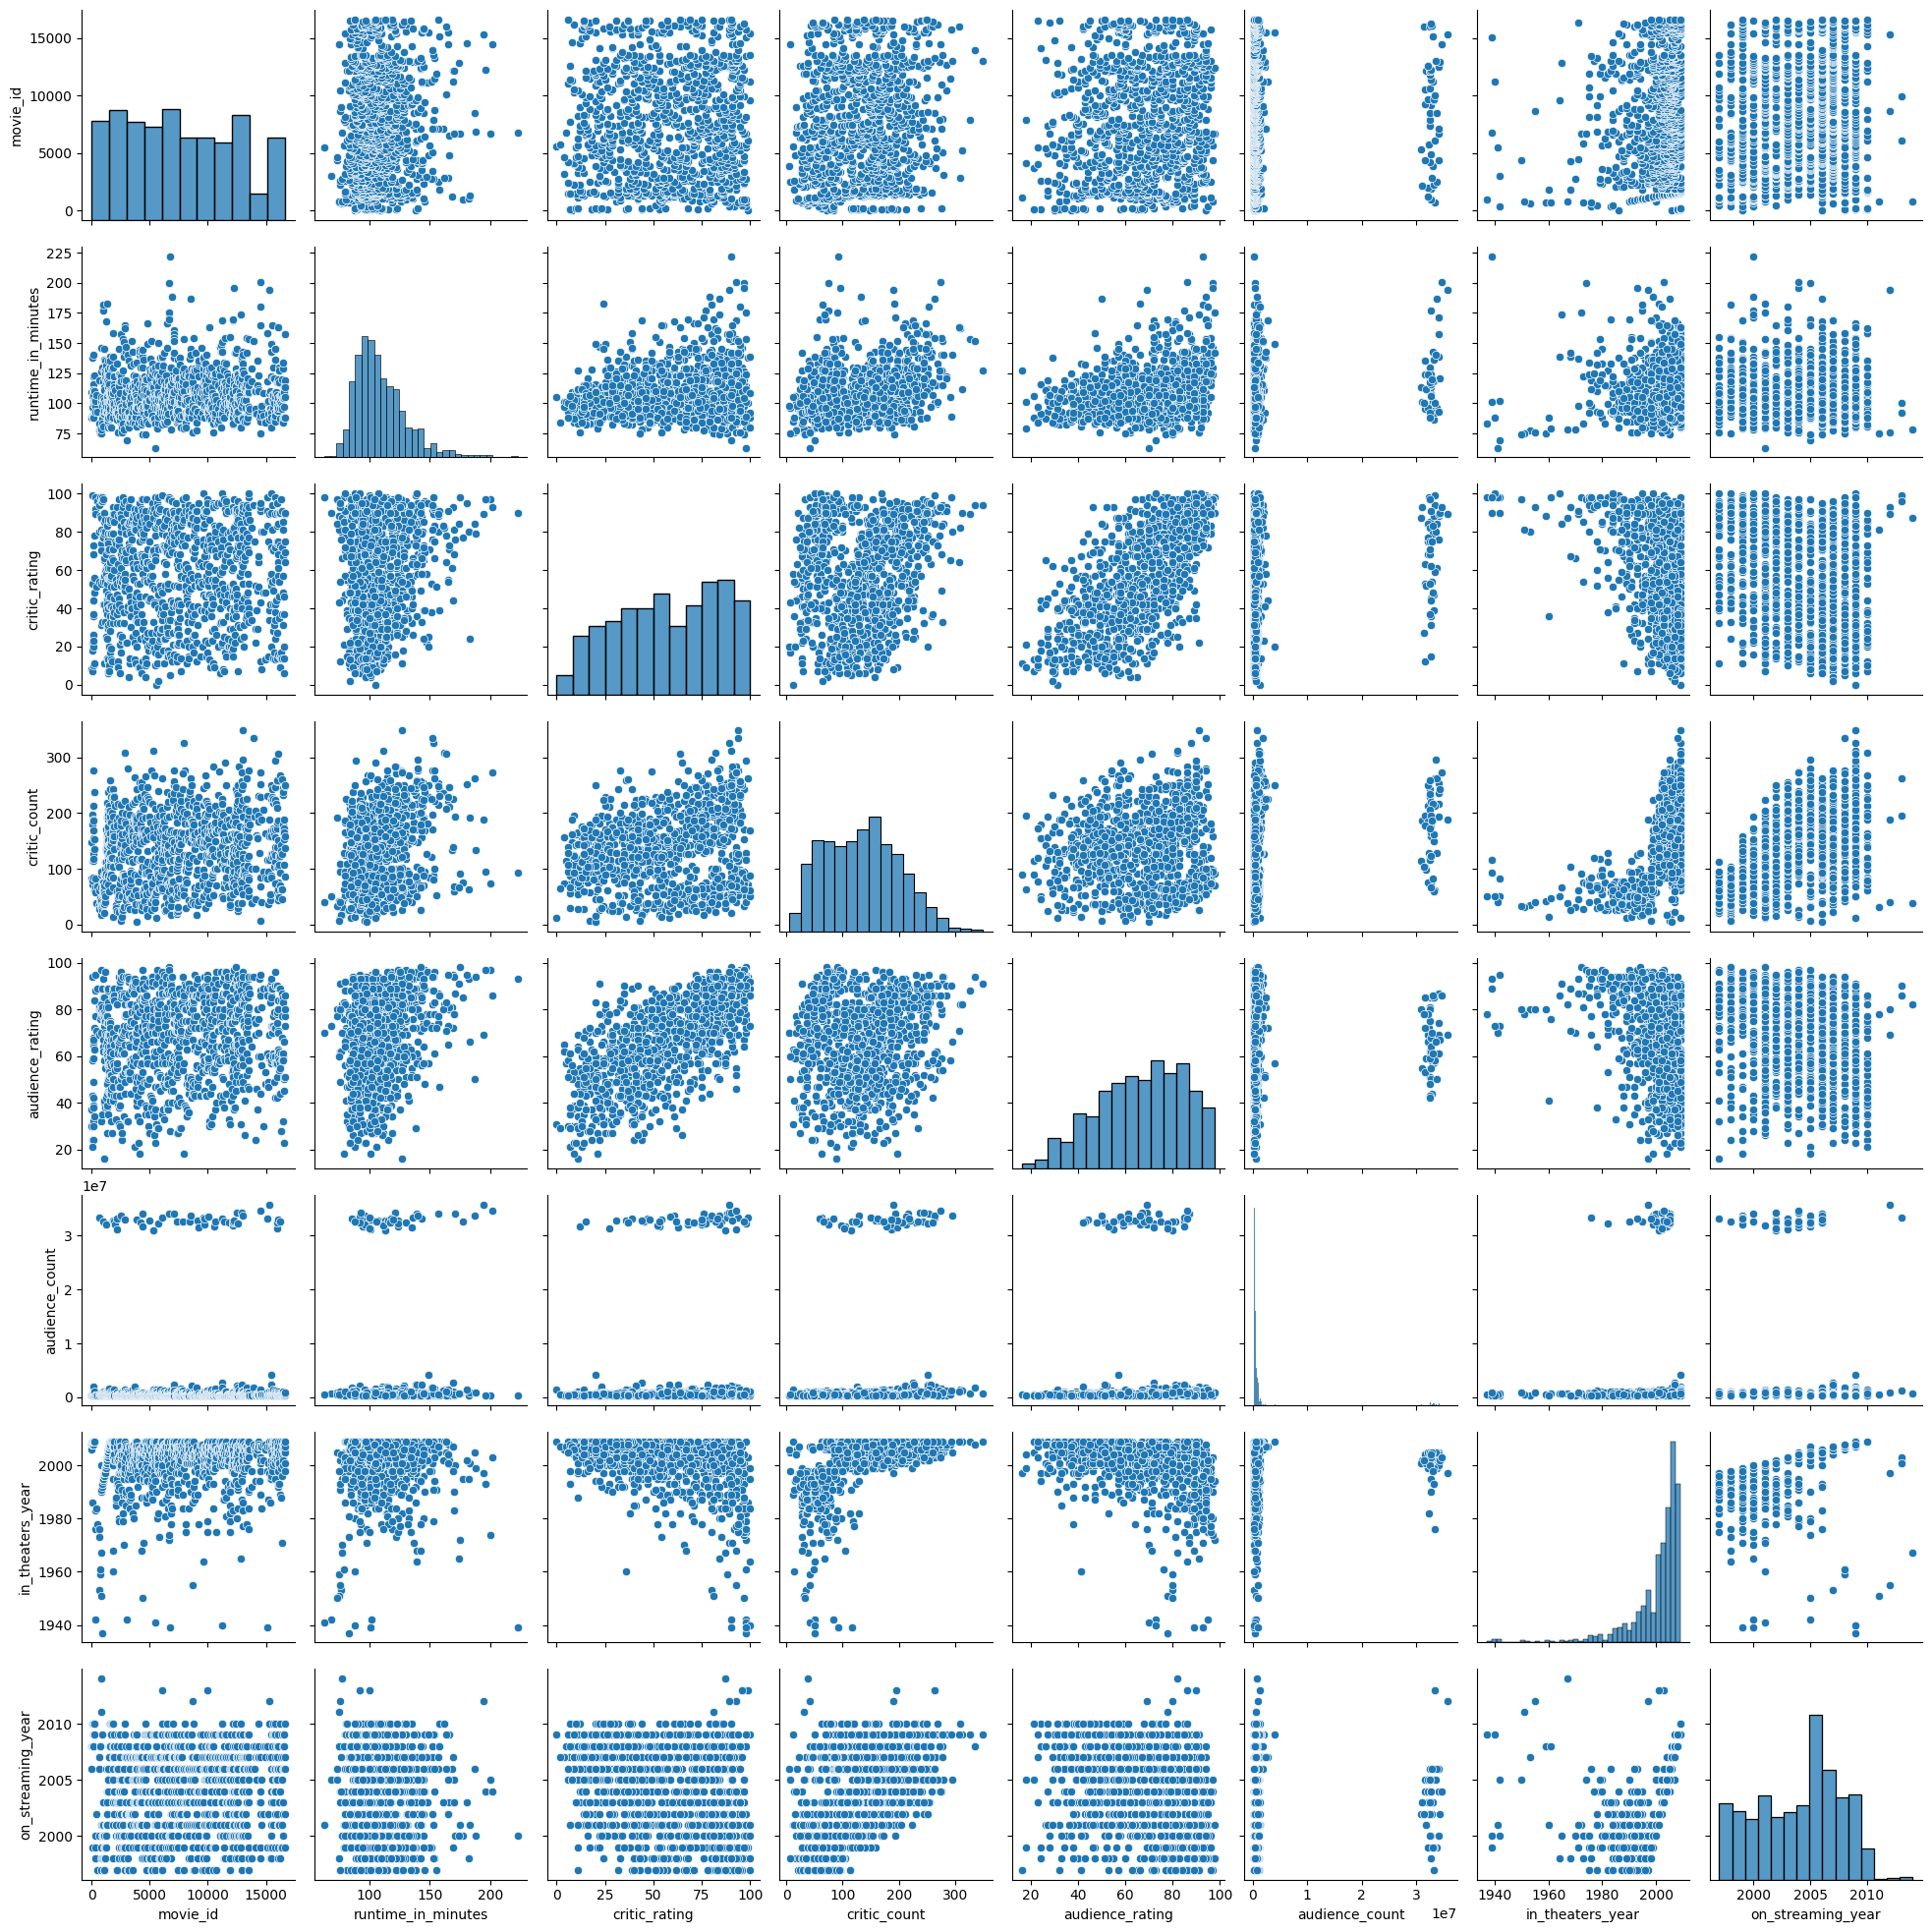

In [86]:
# use sns.pairplot(dataframe) to create the pairplot
sns.pairplot(df_popular)
plt.show();

**Insights:**
- Critic rating has a linear relationship and high correlation with audience rating. It can be seen from the scatter plot, as critic rating increasing, audience rating tend to increase as well.
- There is no correlation between runtime with ratings. From the scatterplot of critics rating vs runtime and audience rating vs runtime, we can see there is no pattern on it. This implies that runtime is not an effective strategy to increase rating. Movie producers should focus more on improving the quality of the content rather than the quantity of runtime.
- Some movies were release at 1940s in theathers, but the earlies movies on streaming platform were added in the late 1990s. This is because streaming platforms did not exist in earlier year. Most movies on streaming platforms are clustered around 2000 and later. Although older movies are added to the streaming platform, the number is just a small amount, compared to the newer released.

### 6. More Insights

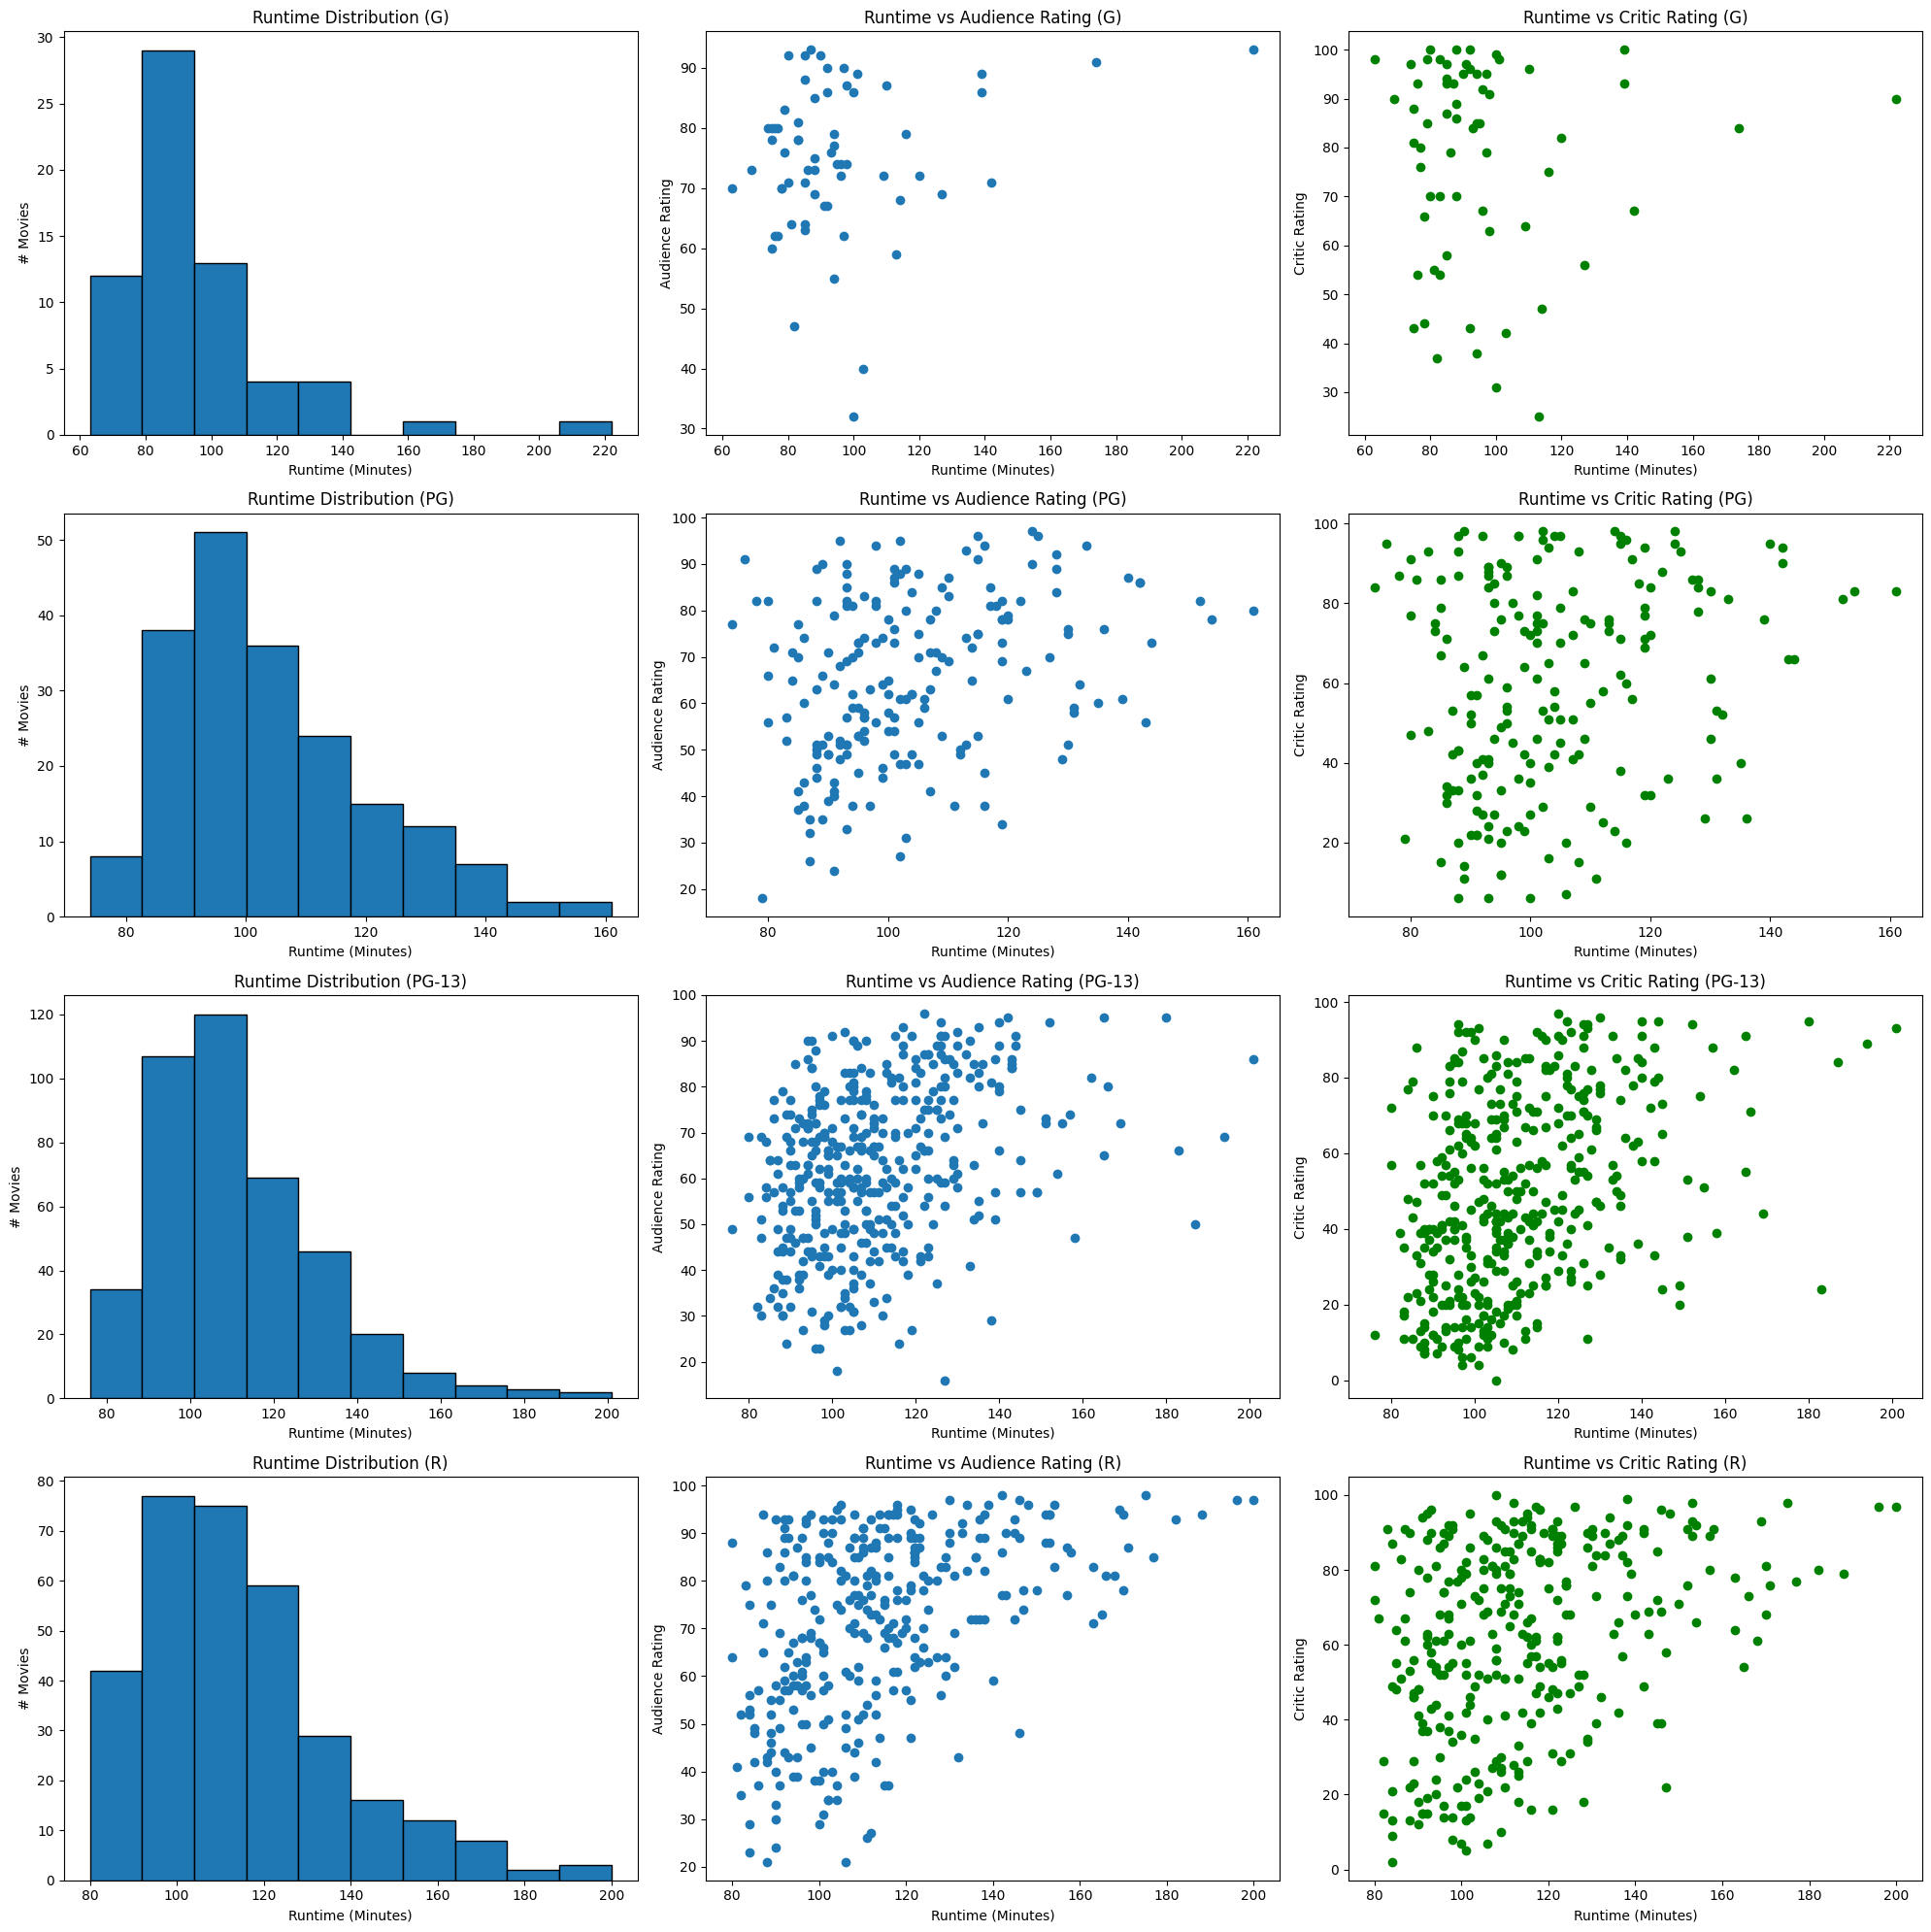

In [87]:
plt.figure(figsize=(20, 20)) 

# For each rating ('G', 'PG', 'PG-13', 'R'), add histograms and scatterplots
ratings = ['G', 'PG', 'PG-13', 'R']
for i, rating in enumerate(ratings):
    filtered_data = df_popular[df_popular['rating'] == rating]
    
    # Histogram of runtime
    plt.subplot(4, 3, i * 3 + 1)
    plt.hist(filtered_data['runtime_in_minutes'], edgecolor='black', bins=10)
    plt.title(f'Runtime Distribution ({rating})')
    plt.xlabel('Runtime (Minutes)')
    plt.ylabel('# Movies')
    
    # Scatterplot of runtime vs audience rating
    plt.subplot(4, 3, i * 3 + 2)
    plt.scatter(filtered_data['runtime_in_minutes'], filtered_data['audience_rating'])
    plt.title(f'Runtime vs Audience Rating ({rating})')
    plt.xlabel('Runtime (Minutes)')
    plt.ylabel('Audience Rating')
    
    # Scatterplot of runtime vs critic rating
    plt.subplot(4, 3, i * 3 + 3)
    plt.scatter(filtered_data['runtime_in_minutes'], filtered_data['critic_rating'], color='green')
    plt.title(f'Runtime vs Critic Rating ({rating})')
    plt.xlabel('Runtime (Minutes)')
    plt.ylabel('Critic Rating')

# Tight layout for better spacing
plt.tight_layout()
plt.show()

**Insights:**
- From the histogram, it is clear that G-rated movies have the shortest runtime, while PG-13 and R movies tend to be longer. This might be because they have more complex movie scenario.
- There is an outlier in the PG-13 movie category, with 2 datapoints showing runtime below 25 mintues. I will clean this data in the next step. These can be considered as outliers because based on the other data, the minimum runtime for most movies ends after 60 mintues. After removing these outliers, I can see there is a slight pattern, as runtime increases, both audience and critic ratings tend to increase slightly.
- Looking at the scatterplot, the trend for audience and critic ratings is consistent across all movie types. One interesting observation is that longer runtime movies tend to recieve higher ratings from critics.

In [88]:
# Remove 2 outliers shown on PG-13
outliers = df_popular[(df_popular['rating'] == 'PG-13') & (df_popular['runtime_in_minutes'] < 25)]
outliers

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,in_theaters_year,on_streaming_year


In [89]:
# Let's remove both datapoints
df_popular = df_popular.drop(outliers.index)
df_popular[(df_popular['rating'] == 'PG-13') & (df_popular['runtime_in_minutes'] < 25)]

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,in_theaters_year,on_streaming_year


## 3. Feature Engineering

Before spliting the data into train and test data, I noticed there are some outliers on the df_popular, the runtime_in_minutes, so of them have a low runtime that doesn't make sense. So, we will filter out the data first.

From the data cleaning part, we noticed that the outliers lie for runtime < 25 minutes. So, we will check how many rows out there. If it is just a few portions of the data, let's remove it.

In [90]:
# check the whole size of the data
df.shape

(16455, 15)

In [91]:
# check the total data that have runtime_in_minutes less than 25
df[df['runtime_in_minutes'] < 25].shape

(0, 15)

Since it's just 22 out of 16k data, we will remove the data.

In [92]:
# change df to the original df with runtime_in_minutes >= 25 based on our findings.
df = df[df['runtime_in_minutes'] >= 25]
df.shape

(16455, 15)

In [93]:
# check the distribution
df['runtime_in_minutes'].describe()

count    16455.000000
mean       102.328897
std         19.304360
min         25.000000
25%         90.000000
50%         99.000000
75%        111.000000
max        283.000000
Name: runtime_in_minutes, dtype: float64

Here it shows there is a datapoint that have 2000 minutes ~ 33 hours of runtime, which doesn't make sense, so we will try to remove it.

In [94]:
# remove the 2000 minutes and check the distribution again
df = df[df['runtime_in_minutes'] != 2000]
df['runtime_in_minutes'].describe()

count    16455.000000
mean       102.328897
std         19.304360
min         25.000000
25%         90.000000
50%         99.000000
75%        111.000000
max        283.000000
Name: runtime_in_minutes, dtype: float64

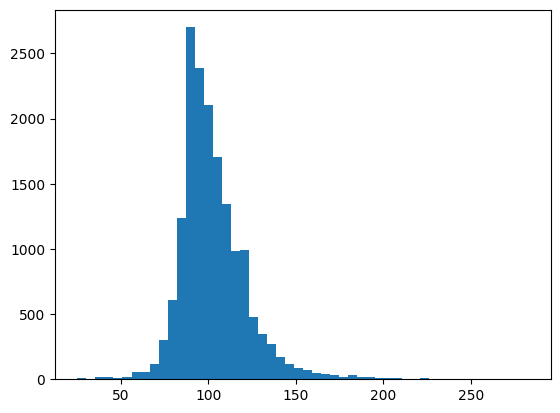

In [95]:
# check the distribution by using histogram and change the bins to see it more deeply
plt.hist(df['runtime_in_minutes'], bins = 50)
plt.show()

In [96]:
# Based on the histogram, we can see there are data more with runtime_in_minutes more than 300 minutes. Let's check what's in it
df[df['runtime_in_minutes'] > 300]

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,in_theaters_year,on_streaming_year


Let's remove these (runtime_in_minutes > 300) data as well, because it will skewed the data.

In [97]:
# change the df into df with runtime_in_minutes less than or equal to 300
df = df[df['runtime_in_minutes'] <= 300]

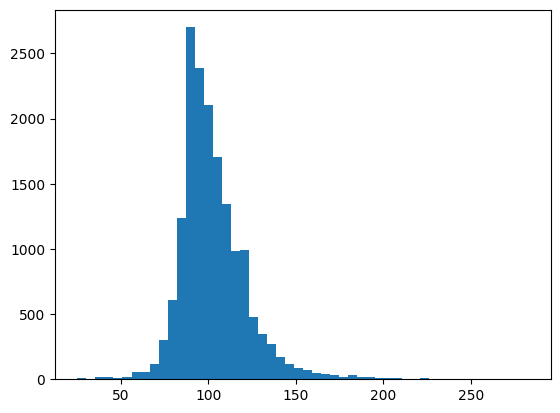

In [98]:
# check the histogram again
plt.hist(df['runtime_in_minutes'], bins = 50)
plt.show();

### Next, we will split the data into train and test data. If you use the movie_data.csv, you can start your code here. The movie_data.csv is the cleaned data that I have compiled before spliting the data and creating the machine learning model.

In [99]:
# Split the data into a training and test set, with the training data including movies released in theatres before 2010 and the test data including movies released in theatres in 2010 and after.
# The year problem has been fixed on the first part of the data cleaning. So, we will split the data directly.
train_data = df[df['in_theaters_year'] < 2010]
test_data = df[df['in_theaters_year'] >= 2010]

### 8. If your goal is to predict the critic_rating before the first critic or audience rating gets posted for a movie, which columns in the data should you NOT use to create features? Update your training and test data sets to NOT include these columns.

To predict the first critic or audience rating, there are 3 features that we should remove:
- critic_count
- audience_rating
- audience_count

The purpose is because we want to predict the rating before the first critic/audience rating.

Why I don't drop the critic_rating? Because it is the one we want to predict. Feature critic_rating will be the target variable.

In [100]:
# drop the variables that we can't use for the training and testing.
train_data = train_data.drop(['critic_count', 'audience_rating', 'audience_count'], axis = 1)
test_data = test_data.drop(['critic_count', 'audience_rating', 'audience_count'], axis = 1)

In [101]:
train_data.head()

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,in_theaters_year,on_streaming_year
2,3,10,Blake Edwards' 10 stars Dudley Moore as George...,R,"Comedy, Romance",Blake Edwards,1979-10-05,1997-08-27,118.0,68,1979.0,1997.0
3,4,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",None,"Classics, Drama",Sidney Lumet,1957-04-13,2001-03-06,95.0,100,1957.0,2001.0
4,5,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,1954-01-01,2003-05-20,127.0,89,1954.0,2003.0
5,6,"10,000 B.C.",A young outcast from a primitive tribe is forc...,PG-13,"Action & Adventure, Classics, Drama",Roland Emmerich,2008-03-07,2008-06-24,109.0,8,2008.0,2008.0
7,8,3:10 to Yuma,"Desperate for money, frontier rancher Van Hefl...",None,"Classics, Drama, Western",Delmer Daves,1957-08-07,2002-04-02,92.0,96,1957.0,2002.0


### 9. Create new dataframe from training data with movie_title, runtime_in_minutes, kid_friendly (1 if G or PG, 0 if others), dummy variable columns for each genre

In [102]:
# create a new dataframe called the train_data_update
train_data_update = train_data[['movie_title', "runtime_in_minutes"]]

In [103]:
# apply 1 if rating is G or PG, else 0
train_data_update['kid_friendly'] = train_data['rating'].apply(lambda x: 1 if x in ['G', 'PG'] else 0)

/var/folders/nr/2_l0dxkj7vxfbxy3c016j3s00000gn/T/ipykernel_62900/3979386949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_update['kid_friendly'] = train_data['rating'].apply(lambda x: 1 if x in ['G', 'PG'] else 0)


In [104]:
# separate for each genre by , separator and get the dummies of it
genre_dum = train_data['genre'].str.get_dummies(sep = ', ')

# combine the genre_dum and the train_data_update
train_data_update = pd.concat([train_data_update, genre_dum], axis = 1)

In [105]:
train_data_update.head()

,movie_title,runtime_in_minutes,kid_friendly,Action & Adventure,Animation,Anime & Manga,Art House & International,Classics,Comedy,Cult Movies,...,Horror,Kids & Family,Musical & Performing Arts,Mystery & Suspense,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western
2,10,118.0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,12 Angry Men (Twelve Angry Men),95.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"20,000 Leagues Under The Sea",127.0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,"10,000 B.C.",109.0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3:10 to Yuma,92.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


### 10. Create 3 new features that you think will do a good job predicting the critic_rating. Each new feature should use various combinations of the columns from your training data

In [106]:
train_data_update.columns

Index(['movie_title', 'runtime_in_minutes', 'kid_friendly',
       'Action & Adventure', 'Animation', 'Anime & Manga',
       'Art House & International', 'Classics', 'Comedy', 'Cult Movies',
       'Documentary', 'Drama', 'Faith & Spirituality', 'Gay & Lesbian',
       'Horror', 'Kids & Family', 'Musical & Performing Arts',
       'Mystery & Suspense', 'Romance', 'Science Fiction & Fantasy',
       'Special Interest', 'Sports & Fitness', 'Television', 'Western'],
      dtype='object')

In [107]:
# 1. Total genre. Higher genre means the film is more complex because it contains more genre on it. We can include this into our model because I assume there will be a non-significant variables on the model. So, I guess it will not be a duplicated variables with the one-hot encoding.
train_data_update['total_genre'] = train_data_update[genre_dum.columns].sum(axis = 1)
train_data_update.head()

,movie_title,runtime_in_minutes,kid_friendly,Action & Adventure,Animation,Anime & Manga,Art House & International,Classics,Comedy,Cult Movies,...,Kids & Family,Musical & Performing Arts,Mystery & Suspense,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western,total_genre
2,10,118.0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,2
3,12 Angry Men (Twelve Angry Men),95.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
4,"20,000 Leagues Under The Sea",127.0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3
5,"10,000 B.C.",109.0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3
7,3:10 to Yuma,92.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,3


In [108]:
# 2. Total words used in a title
# split the title by space and take the length of it
train_data_update['title_word_count'] = train_data_update['movie_title'].apply(lambda x: len(str(x).split()))
train_data_update.head()

,movie_title,runtime_in_minutes,kid_friendly,Action & Adventure,Animation,Anime & Manga,Art House & International,Classics,Comedy,Cult Movies,...,Musical & Performing Arts,Mystery & Suspense,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western,total_genre,title_word_count
2,10,118.0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,2,1
3,12 Angry Men (Twelve Angry Men),95.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,6
4,"20,000 Leagues Under The Sea",127.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,5
5,"10,000 B.C.",109.0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3,2
7,3:10 to Yuma,92.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,3,3


In [109]:
# 3. In theather and on streaming release decade, this maybe important because the quality of movie keeps on improving day by day
train_data_update['release_decade_theather'] = (train_data['in_theaters_year'] // 10) * 10
train_data_update['release_decade_streaming'] = (train_data['on_streaming_year'] // 10) * 10
train_data_update.head()

,movie_title,runtime_in_minutes,kid_friendly,Action & Adventure,Animation,Anime & Manga,Art House & International,Classics,Comedy,Cult Movies,...,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western,total_genre,title_word_count,release_decade_theather,release_decade_streaming
2,10,118.0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,2,1,1970.0,1990.0
3,12 Angry Men (Twelve Angry Men),95.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,2,6,1950.0,2000.0
4,"20,000 Leagues Under The Sea",127.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,3,5,1950.0,2000.0
5,"10,000 B.C.",109.0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,3,2,2000.0,2000.0
7,3:10 to Yuma,92.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,3,3,1950.0,2000.0


# 4. Modelling

### 11. Transform train and test data

In [110]:
# X_train is using the features that we have composed during the feature engineering and the y_train will be the predicted value, which is the critic rating
X_train = train_data_update
y_train = train_data['critic_rating']

Transform test data to have the same features that we want for the training data

In [111]:
# take the movie title and runtime_in_minute to compose the X_test, next we will add features that we have created during feature engineering for training data.
X_test = test_data[['movie_title', 'runtime_in_minutes']]

In [112]:
# apply the kid_friendly variables. Use apply function if the rating is G or PG, then 1, otherwise it is 0.
X_test['kid_friendly'] = test_data['rating'].apply(lambda x: 1 if x in ['G', 'PG'] else 0)

/var/folders/nr/2_l0dxkj7vxfbxy3c016j3s00000gn/T/ipykernel_62900/953756731.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['kid_friendly'] = test_data['rating'].apply(lambda x: 1 if x in ['G', 'PG'] else 0)


In [113]:
# separate for each genre by , separator and get the dummies of it
genre_dum_test = test_data['genre'].str.get_dummies(sep = ', ')

# combine the genre_dum and the train_data_update
X_test = pd.concat([X_test, genre_dum_test], axis = 1)
X_test.head()

,movie_title,runtime_in_minutes,kid_friendly,Action & Adventure,Animation,Anime & Manga,Art House & International,Classics,Comedy,Cult Movies,...,Horror,Kids & Family,Musical & Performing Arts,Mystery & Suspense,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western
0,Percy Jackson & the Olympians: The Lightning T...,83.0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,Please Give,90.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
101,Fireflies in the Garden,98.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134,The Back-up Plan,104.0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
136,The Oxford Murders,110.0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [114]:
# Additional features
# 1. Total genre 
X_test['total_genre'] = X_test[genre_dum_test.columns].sum(axis = 1)

# 2. Word count of the title 
X_test['title_word_count'] = X_test['movie_title'].apply(lambda x: len(str(x).split()))

# 3. In theather and on streaming release decade
X_test['release_decade_theather'] = (test_data['in_theaters_year'] // 10) * 10
X_test['release_decade_streaming'] = (test_data['on_streaming_year'] // 10) * 10

In [115]:
X_test.head()

,movie_title,runtime_in_minutes,kid_friendly,Action & Adventure,Animation,Anime & Manga,Art House & International,Classics,Comedy,Cult Movies,...,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western,total_genre,title_word_count,release_decade_theather,release_decade_streaming
0,Percy Jackson & the Olympians: The Lightning T...,83.0,1,1,0,0,0,0,1,0,...,0,1,0,0,0,0,4,8,2010.0,2010.0
1,Please Give,90.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,2,2010.0,2010.0
101,Fireflies in the Garden,98.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,4,2010.0,2010.0
134,The Back-up Plan,104.0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,2,3,2010.0,2010.0
136,The Oxford Murders,110.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,4,3,2010.0,2010.0


In [116]:
# y_test will be the critic rating of the test data
y_test = test_data['critic_rating']

###  12. Make sure that your X_train, y_train, X_test and y_test data sets only contain columns of numeric and non-null values. Explain and justify how you decide to deal with data issues

1. We will remove the movie_title since it's non-numeric. To fit into a regression problem, all of the input should be numeric.

In [117]:
# we will drop the movie title because it is non-numeric
X_train = X_train.drop('movie_title', axis = 1)
X_test = X_test.drop('movie_title', axis = 1)

2. Check null-values

In [118]:
print(X_train.isnull().values.any())

False


In [119]:
np.isinf(X_train).any()

runtime_in_minutes           False
kid_friendly                 False
Action & Adventure           False
Animation                    False
Anime & Manga                False
Art House & International    False
Classics                     False
Comedy                       False
Cult Movies                  False
Documentary                  False
Drama                        False
Faith & Spirituality         False
Gay & Lesbian                False
Horror                       False
Kids & Family                False
Musical & Performing Arts    False
Mystery & Suspense           False
Romance                      False
Science Fiction & Fantasy    False
Special Interest             False
Sports & Fitness             False
Television                   False
Western                      False
total_genre                  False
title_word_count             False
release_decade_theather      False
release_decade_streaming     False
dtype: bool

In [120]:
np.isinf(X_train).any()

runtime_in_minutes           False
kid_friendly                 False
Action & Adventure           False
Animation                    False
Anime & Manga                False
Art House & International    False
Classics                     False
Comedy                       False
Cult Movies                  False
Documentary                  False
Drama                        False
Faith & Spirituality         False
Gay & Lesbian                False
Horror                       False
Kids & Family                False
Musical & Performing Arts    False
Mystery & Suspense           False
Romance                      False
Science Fiction & Fantasy    False
Special Interest             False
Sports & Fitness             False
Television                   False
Western                      False
total_genre                  False
title_word_count             False
release_decade_theather      False
release_decade_streaming     False
dtype: bool

1. So, I have remove the movie_title because it's non-numeric data.
2. I have noticed that there is no null values on the train and test data. This means all of the data have runtime_in_minutes and genre.

### 13.  Fit 3 linear regression models on the training data:
- Model 1: Use only runtime_in_minutes
- Model 2: Use runtime_in_minutes and kid_friendly
- Model 3: Use runtime_in_minutes, kid_friendly and the dummy columns for the genres

In [121]:
# model 1, use LinearRegression() from scikit-learn to fit the model, using only runtime
model1 = LinearRegression()
model1.fit(X_train[['runtime_in_minutes']], y_train)

LinearRegression()

In [122]:
# model 2
model2 = LinearRegression()
model2.fit(X_train[['runtime_in_minutes', 'kid_friendly']], y_train)

LinearRegression()

In [123]:
# model 3
X_train_reduced = X_train.iloc[:, :-4] # not including the features that I have created on the Feature Engineering part
model3 = LinearRegression()
model3.fit(X_train_reduced, y_train)

LinearRegression()

### 14. Score the linear regression models on the test data by writing a function where you can input the y_test and y_pred values (y_pred = predicted values after you apply the fitted model to your X_test data), and it outputs the following metrics: R2, MAE and RMSE. Apply the function to the three models that you’ve fit so far

In [132]:
# create a function to evaluate the model, so we won't be calculating manually for each model. I used the library under sklearn, which is from the sklearn.metrics
def evaluate_model(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return {"R^2": r2, "MAE": mae, "RMSE": rmse}

# predict the y from the y_test for each model
y_pred1 = model1.predict(X_test[['runtime_in_minutes']])
y_pred2 = model2.predict(X_test[['runtime_in_minutes', 'kid_friendly']])
y_pred3 = model3.predict(X_test.iloc[:, :-4])

# evaluate the result of each model
result1 = evaluate_model(y_test, y_pred1)
result2 = evaluate_model(y_test, y_pred2)
result3 = evaluate_model(y_test, y_pred3)

# print the results
print("Model 1 Metrics:", result1)
print("Model 2 Metrics:", result2)
print("Model 3 Metrics:", result3)

Model 1 Metrics: {'R^2': -0.0032414917168293034, 'MAE': np.float64(24.37555513017468), 'RMSE': np.float64(28.316365973378193)}
Model 2 Metrics: {'R^2': -0.003960569640903078, 'MAE': np.float64(24.419118439404375), 'RMSE': np.float64(28.326512097993184)}
Model 3 Metrics: {'R^2': 0.1513712373688707, 'MAE': np.float64(21.965197976932245), 'RMSE': np.float64(26.043158117283227)}


### 15. Which model performs the best so far? Which features seem to do a good job predicting the critic rating (hint: you can check p-values using statsmodels)?

So far, the best model is the model that includes runtime_in_mintues, kid_friendly, and all the dummy variables for genres

In [ ]:
X_train_reduced = sm.add_constant(X_train.iloc[:, :-4])  # Exclude last 4 columns and add a constant to add the bias term
ols_model1 = sm.OLS(y_train, X_train_reduced).fit() # fit to an OLS linear regression using the X_train_reduced to predict y_train
print(ols_model1.summary()) # print the summary of the ols model to check the significancy of each feature

                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     127.3
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:49:39   Log-Likelihood:                -45234.
No. Observations:                9742   AIC:                         9.052e+04
Df Residuals:                    9718   BIC:                         9.069e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

From the result above we can see that the variables that is important to predict the critic ranting is vairbales that have p-value < 0.05. p-value < 0.05 means the variable is statistically significant.
- runtime_in_minutes
- kid_friendly
- All of the genres dummy variables except Anime & Manga, Cult Movies, Gay & Lesbian, Romance, Science Fiction & Fantasy, Sports & Fitness

Positive coefficient means, the critic rating will be higher as we increase the coefficient of the positive slope variables (only vars that are statistically signifcant):
- runtime_in_minutes
- kids_friendly
- Animation
- Art House & International
- Classics
- Documentary
- Drama
- Musical & Performing Arts
- Special Interest
- Television
- Western

This means, all of the genre that are mentioned above will increase the score of the critics rating.

Negative coefficient means, the critic rating will be lower as we increase the unit of the negative slope variables (only vars that are statistically significant):
- Action & Adventure
- Comedy
- Faith & Spirituality
- Horror
- Kids & Family
- Mystery & Suspense 

### 16. Try fitting 3 more linear regression models on your own using a combination of the columns so far (runtime_in_minutes, kid-friendly and the dummy columns for genre) and your newly engineered features.

I will try to use total genre onto our model and exclude the variables that is insignificant towards critics rating. This may help to improve the model because we have remove some of the variables and it may explains how many genres are there in the movie.

In [ ]:
# drop columns that are not statistically significant, include the total_genre
X_train_selected = X_train.drop(columns = ['Anime & Manga', 'Cult Movies', 'Gay & Lesbian', 'Romance', 'Science Fiction & Fantasy', 'Sports & Fitness', 'title_word_count', 'release_decade_theather', 'release_decade_streaming'])

# add a constant to the X_train_selected for the bias term
X_train_selected = sm.add_constant(X_train_selected)

# Fit it to the X_train_selected to regress y_train using the OLS Linear Regression
ols_model2 = sm.OLS(y_train, X_train_selected).fit()

# print the summary output of the model
print(ols_model2.summary())

                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     162.5
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:49:47   Log-Likelihood:                -45236.
No. Observations:                9742   AIC:                         9.051e+04
Df Residuals:                    9723   BIC:                         9.065e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

It seems that the total genre is not a good predictor here, because we can see that when I didn't use the total_genre, all of the variables are significant. Then, when I included title_word_count, some other variables become insignificant to the predictor. This means, the total_genre is describing some of the genre variables. This make sense because total_genre is basically the total count for every genre. So, there may be a high correlation between total_genre with Musical & Performing Arts and Television.

Eventhough it is statistically significant, but it reducees the significancy of other variables. So, I decided to remove this variablees, the total_genre and try the other variables included on our model.

Next, I will try to use the title_word_count onto our model. I will check whether the title word count will have an impact towards the critic rating or not.

In [143]:
# drop columns that are not statistically significant, include the title_word_count
X_train_selected = X_train.drop(columns = ['Anime & Manga', 'Cult Movies', 'Gay & Lesbian', 'Romance', 'Science Fiction & Fantasy', 'Sports & Fitness', 'release_decade_theather', 'release_decade_streaming', 'total_genre'])
X_train_selected = sm.add_constant(X_train_selected)
ols_model3 = sm.OLS(y_train, X_train_selected).fit()
print(ols_model3.summary())

                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     163.8
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:49:52   Log-Likelihood:                -45227.
No. Observations:                9742   AIC:                         9.049e+04
Df Residuals:                    9723   BIC:                         9.063e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

It seems that the title_word_count variable is statistically significant towards the critics rating. It has positive slope, which means that an increase in the title_word_count will also increase the critics rating.

This means that title_word_count is another variable that significantly impacts the critics rating.

In [144]:
# drop columns that are not statistically significant based on the previous model, and add the release_decade_theater and release_decade_streaming
X_train_selected = X_train.drop(columns = ['Anime & Manga', 'Cult Movies', 'Gay & Lesbian', 'Romance', 'Science Fiction & Fantasy', 'Sports & Fitness', 'total_genre'])
X_train_selected = sm.add_constant(X_train_selected)
ols_model4 = sm.OLS(y_train, X_train_selected).fit()
print(ols_model4.summary())

                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     201.7
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:50:01   Log-Likelihood:                -44827.
No. Observations:                9742   AIC:                         8.970e+04
Df Residuals:                    9721   BIC:                         8.985e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Here, we can see that release decade theather is another strong predictor. We can see from the t statistics, it is the highest one among the others. Aside from that, we notice that because it has high t-stat, it has a very low p-value, which means that the variable is statistically significant to the model.

Since it has a negative slope, this means that as the movie’s release year on theather becomes more recent, the critic rating decreases. This suggests that critics tend to favor older movies over newly released ones.

Release decade theather has removed several significant predictors as well like the Classics, Musical & Performing Arts, and kid_friendly, which means that the release_decade has explain everything from it. My assumptions here is that Classics and Musical & Performing Arts were released on theather for an older generation, but nowadays, there are more kid_friendly movies. That's why it became unsignificant. I will also remove kids & family because it will be a highly correlated with kid_friendly. When I remove kid_friendly, it can be a bad predictor because it has been explained by the released_decade_theather.

The release_decade_streaming is not statistically significant, so it is not a good predictor to predict the critic rating.

### 17. Out of the 6 models you created, which model performs the best? Which features seem to do a good job predicting the critic rating?

In [145]:
# drop columns that are not statistically significant based on the previous model
X_train_selected = X_train.drop(columns = ['Anime & Manga', 'Cult Movies', 'Gay & Lesbian', 'Romance', 'Science Fiction & Fantasy', 'Sports & Fitness', 'total_genre', 'Classics', 'Musical & Performing Arts', 'kid_friendly', 'Kids & Family', 'release_decade_streaming'])
X_train_selected = sm.add_constant(X_train_selected)
ols_model5 = sm.OLS(y_train, X_train_selected).fit()
print(ols_model5.summary())

                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     267.9
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:50:09   Log-Likelihood:                -44833.
No. Observations:                9742   AIC:                         8.970e+04
Df Residuals:                    9726   BIC:                         8.981e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

The last model that I tried seems the best model. It has the best adjusted R^2 value. I found out that the release_decade on theather is a strong predictor to predict critic rating.

The features that seems to do a good job predicting the critic rating are:
- release_decade_theather
- runtime_in_minutes
- title_word_count
- Genre types (Action & Adventure, Animation, Art House & International, Comedy, Documentary, Drama, Faith & Spirituality, Horror, Mystery & Suspense, Special Interest, Western)

From the summary above, we can see that:
- Positive slope:
    1. runtime_in_minutes
    2. title_word_count
    3. Animation
    4. Art House & International
    5. Documentary
    6. Drama
    7. Special Interest
    8. Television
    9. Western
- Negative slope:
    1. release_decate_theather
    2. Action & Adventure
    3. Comedy
    4. Faith & Spirituality
    5. Horror
    6. Mystery & Suspense

From this, we can conclude that critics usually give higher ratings to movies with good storytelling and unique themes. These movies are appreciated because they offer more than just entertainment and provide something meaningful. On the other hand, the variables with negative slopes suggest that genres focused more on entertainment might not meet the narrative standards that critics value.

Movies with a longer runtime and a higher title word count tend to get better ratings from critics. However, critics seem to prefer older movies. This might be because older movies are seen as having better scene quality, while newer releases focus more on entertainment.

### 18. List 3 other things you could to do at this point to try and improve your model.

1. Create another type of model to identify critics rating. There may be a non-linear relationship between the variables. Solutions to try is to use the random forest and XGBoost model to predict the critic rating.
2. Add more features to the model, such as actor rating for the actor who acts in the movie or the producer's average rating from the third party data. Can use web scrapping to get the data.
3. Use sentiment analysis to define the overall tone of the movie. This can give additional features that may be useful in the model to predict critic ratings.